In [2]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

  Using cached numpy-2.2.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]━━━━━━━━━━━ 2/3 [pandas]
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import pickle

In [4]:


# Load data paths
TRAIN_CSV = '../Dataset/train_cleaned.csv'
TEST_CSV = '../Dataset/test_cleaned.csv'

# Load training data
train_df = pd.read_csv(TRAIN_CSV)
train_df.head()

# Separate features and target
X = train_df.drop(columns=['satisfaction'])
y = train_df['satisfaction']
num_cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes']
# Create preprocessing pipeline for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'
)

# Apply preprocessing to the data
X_preprocessed = preprocessor.fit_transform(X)

# Setup cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grids
n_estimators_values = [50, 100, 200]
learning_rate_values = [0.01, 0.1, 0.5, 1.0]

# Initialize arrays to store results
mean_val_accuracies = []
mean_val_losses = []
mean_train_accuracies = []
mean_train_losses = []
params = []

# Perform grid search for best hyperparameters
for n_estimators in n_estimators_values:
    for learning_rate in learning_rate_values:
        print(f"\nTraining with n_estimators={n_estimators}, learning_rate={learning_rate}...")
        
        # Create a new AdaBoost model with current parameters
        base_estimator = DecisionTreeClassifier(max_depth=6)
        model = AdaBoostClassifier(
            estimator=base_estimator,  # Using 'estimator' instead of 'base_estimator'
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=42
        )
        
        # Cross-validate
        scores = cross_validate(model, X_preprocessed, y, cv=kf,
                               scoring=['accuracy', 'neg_log_loss'],
                               return_train_score=True)
        
        # Store results
        val_accuracy = scores['test_accuracy'].mean()
        val_loss = -scores['test_neg_log_loss'].mean()
        train_accuracy = scores['train_accuracy'].mean()
        train_loss = -scores['train_neg_log_loss'].mean()
        
        mean_val_accuracies.append(val_accuracy)
        mean_val_losses.append(val_loss)
        mean_train_accuracies.append(train_accuracy)
        mean_train_losses.append(train_loss)
        params.append((n_estimators, learning_rate))
        
        print(f"Validation accuracy: {val_accuracy:.4f}, Train accuracy: {train_accuracy:.4f}")


Training with n_estimators=50, learning_rate=0.01...
Validation accuracy: 0.9347, Train accuracy: 0.9355

Training with n_estimators=50, learning_rate=0.1...
Validation accuracy: 0.9493, Train accuracy: 0.9502

Training with n_estimators=50, learning_rate=0.5...
Validation accuracy: 0.9546, Train accuracy: 0.9576

Training with n_estimators=50, learning_rate=1.0...
Validation accuracy: 0.9553, Train accuracy: 0.9626

Training with n_estimators=100, learning_rate=0.01...
Validation accuracy: 0.9408, Train accuracy: 0.9414

Training with n_estimators=100, learning_rate=0.1...
Validation accuracy: 0.9516, Train accuracy: 0.9524

Training with n_estimators=100, learning_rate=0.5...
Validation accuracy: 0.9579, Train accuracy: 0.9626

Training with n_estimators=100, learning_rate=1.0...
Validation accuracy: 0.9574, Train accuracy: 0.9717

Training with n_estimators=200, learning_rate=0.01...
Validation accuracy: 0.9434, Train accuracy: 0.9443

Training with n_estimators=200, learning_rate=


Best parameters: n_estimators=200, learning_rate=0.5
Best validation accuracy: 0.9592


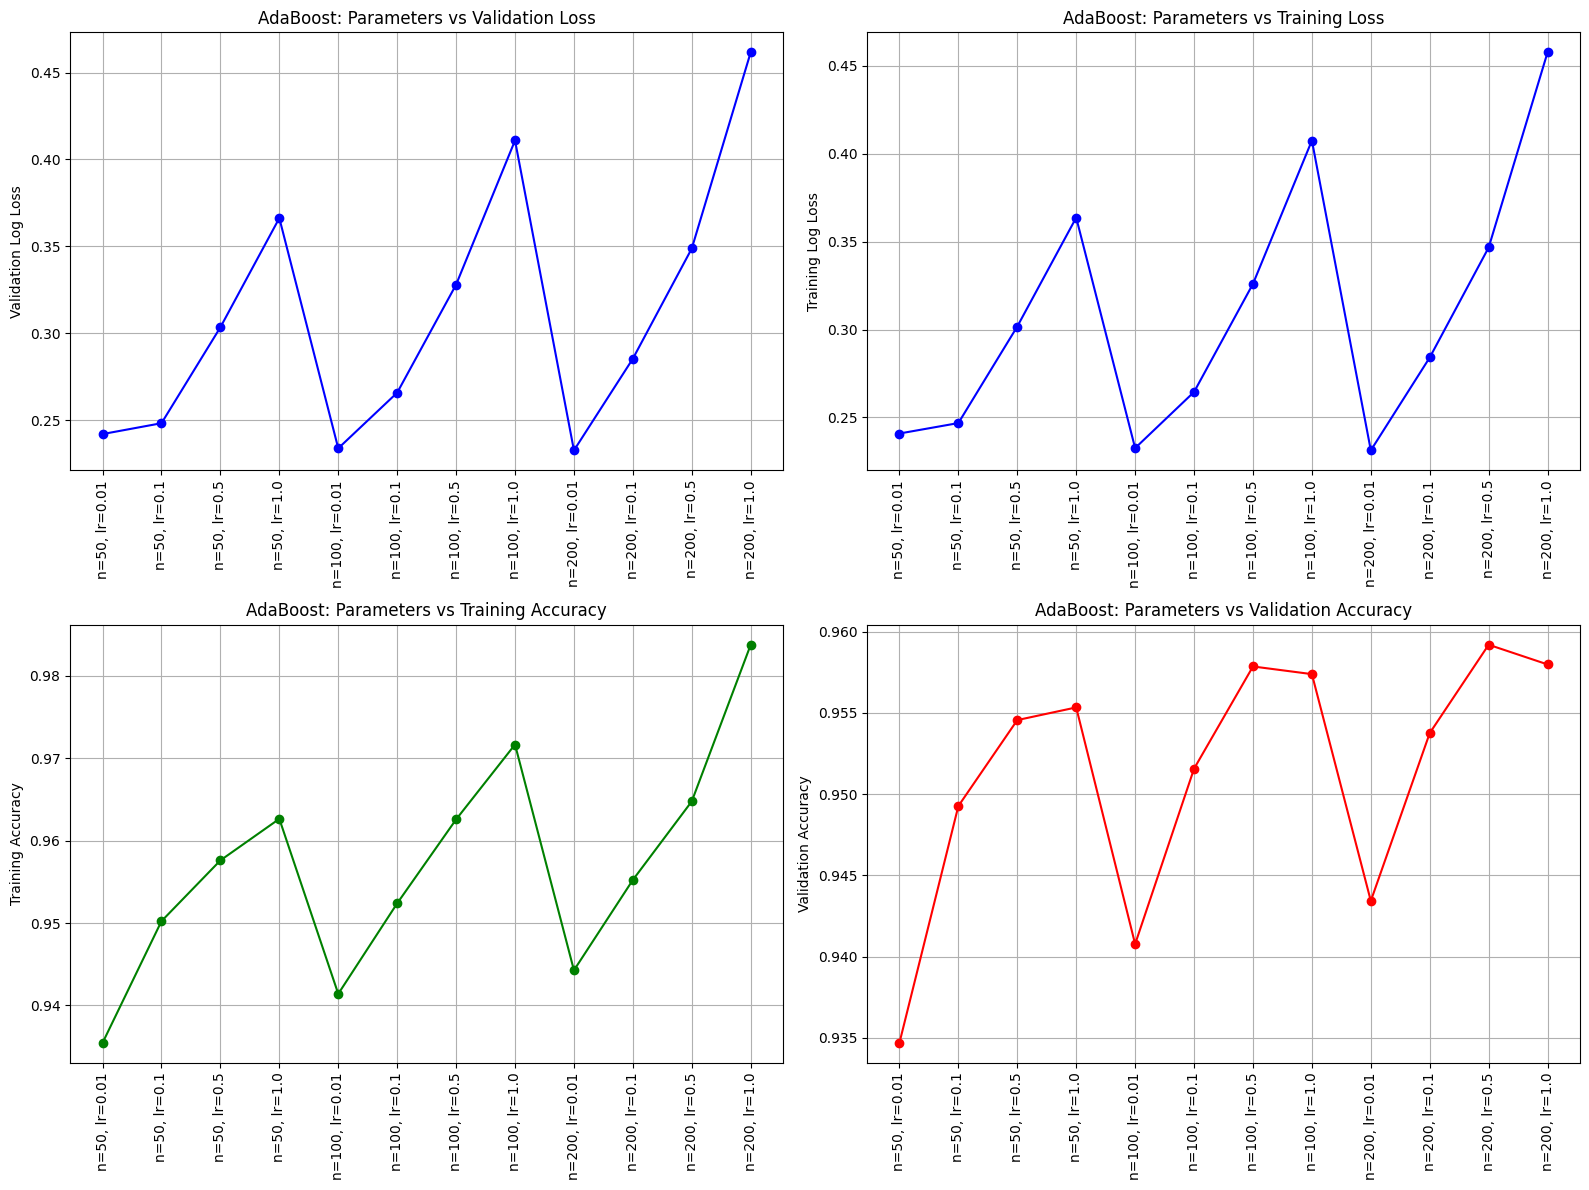

In [5]:

# Find the best parameters
best_idx = np.argmax(mean_val_accuracies)
best_n_estimators, best_lr = params[best_idx]
print(f"\nBest parameters: n_estimators={best_n_estimators}, learning_rate={best_lr}")
print(f"Best validation accuracy: {mean_val_accuracies[best_idx]:.4f}")
# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
param_labels = [f"n={p[0]}, lr={p[1]}" for p in params]

# Validation loss
axs[0, 0].plot(range(len(params)), mean_val_losses, marker='o', color='blue')
axs[0, 0].set_xticks(range(len(params)))
axs[0, 0].set_xticklabels(param_labels, rotation=90)
axs[0, 0].set_ylabel('Validation Log Loss')
axs[0, 0].set_title('AdaBoost: Parameters vs Validation Loss')
axs[0, 0].grid(True)

# Training loss
axs[0, 1].plot(range(len(params)), mean_train_losses, marker='o', color='blue')
axs[0, 1].set_xticks(range(len(params)))
axs[0, 1].set_xticklabels(param_labels, rotation=90)
axs[0, 1].set_ylabel('Training Log Loss')
axs[0, 1].set_title('AdaBoost: Parameters vs Training Loss')
axs[0, 1].grid(True)

# Training accuracy
axs[1, 0].plot(range(len(params)), mean_train_accuracies, marker='o', color='green')
axs[1, 0].set_xticks(range(len(params)))
axs[1, 0].set_xticklabels(param_labels, rotation=90)
axs[1, 0].set_ylabel('Training Accuracy')
axs[1, 0].set_title('AdaBoost: Parameters vs Training Accuracy')
axs[1, 0].grid(True)

# Validation accuracy
axs[1, 1].plot(range(len(params)), mean_val_accuracies, marker='o', color='red')
axs[1, 1].set_xticks(range(len(params)))
axs[1, 1].set_xticklabels(param_labels, rotation=90)
axs[1, 1].set_ylabel('Validation Accuracy')
axs[1, 1].set_title('AdaBoost: Parameters vs Validation Accuracy')
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

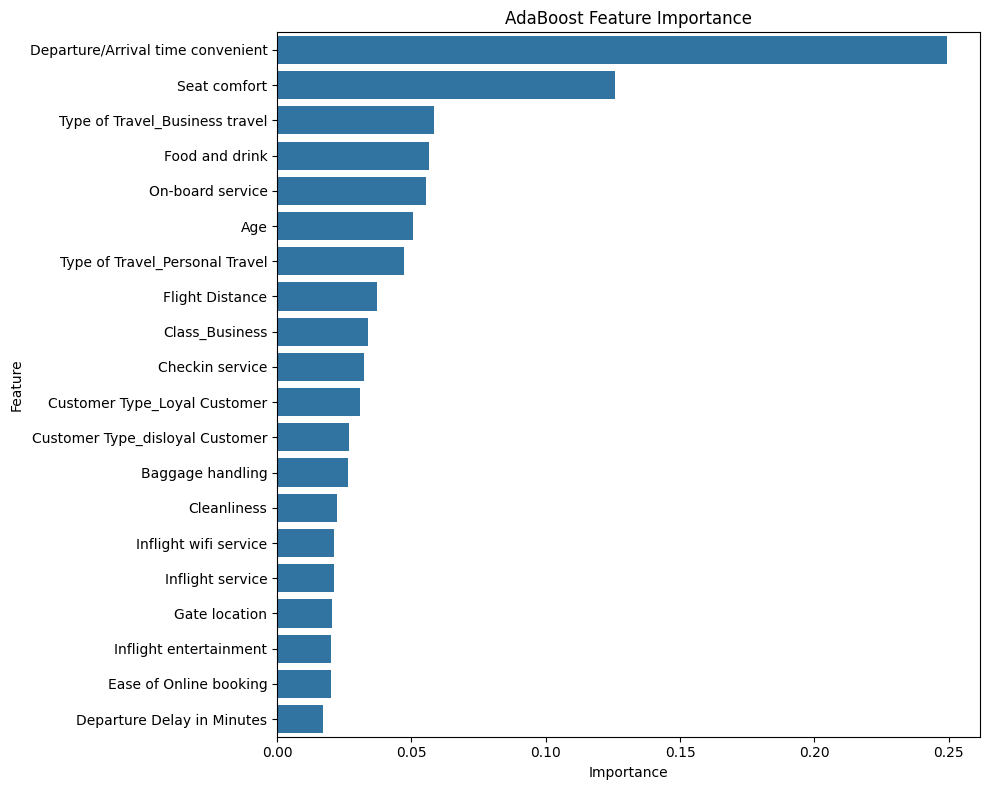


Training Metrics:
Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.98      0.97     58878
        True       0.97      0.95      0.96     45024

    accuracy                           0.96    103902
   macro avg       0.97      0.96      0.96    103902
weighted avg       0.96      0.96      0.96    103902



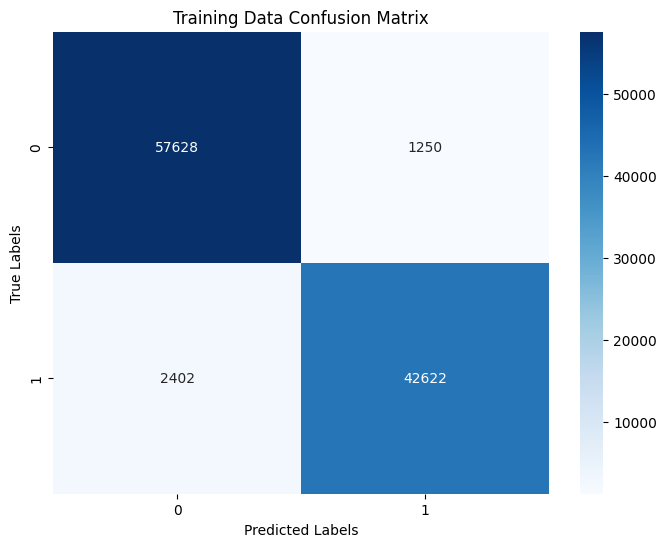


Test Metrics:
Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.97      0.97     14572
        True       0.97      0.94      0.95     11403

    accuracy                           0.96     25975
   macro avg       0.96      0.96      0.96     25975
weighted avg       0.96      0.96      0.96     25975



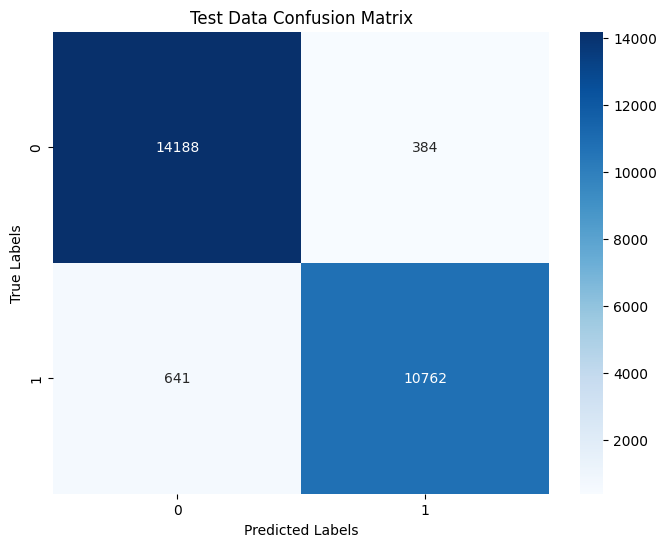

In [6]:
X_train_preprocessed = preprocessor.fit_transform(X)
# Create and train final model
final_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=6),
    n_estimators=best_n_estimators,
    learning_rate=best_lr,
    random_state=42
)

final_model.fit(X_train_preprocessed, y)

if hasattr(final_model, 'feature_importances_'):
    feature_importances = final_model.feature_importances_
    
    feature_names = list(X.columns)
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values('Importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('AdaBoost Feature Importance')
    plt.tight_layout()
    plt.show()

y_pred_train = final_model.predict(X_train_preprocessed)
print("\nTraining Metrics:")
print("=================")
print("Classification Report:")
print(classification_report(y, y_pred_train))

# Confusion matrix for training data
cm_train = confusion_matrix(y, y_pred_train)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Training Data Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Load and evaluate on test data
test_df = pd.read_csv(TEST_CSV)
X_test = test_df.drop(columns=['satisfaction'])
y_test = test_df['satisfaction']

# Preprocess test data using the same preprocessor
X_test_preprocessed = preprocessor.transform(X_test)

# Predictions on test data
y_pred_test = final_model.predict(X_test_preprocessed)
print("\nTest Metrics:")
print("=============")
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

# Confusion matrix for test data
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Test Data Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [7]:
# Save the model
pickle.dump(final_model, open('../Models/adaboost_model3.pkl', 'wb'))
